In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.animation
from scipy import io as sio
import IPython.display as ipd

import pygsp as p

import pandas as pd

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import TextBox

# import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

from spielman_learning import *

# %matplotlib notebook

In [2]:
datadir = Path('data/neuroscience')

In [3]:
connectivity = sio.loadmat(datadir / 'SC.mat')['SC']
n_regions, n_regions = connectivity.shape
print(f'{n_regions} brain regions')

360 brain regions


In [4]:
data_coords = sio.loadmat(datadir / 'Glasser360_2mm_codebook.mat')['codeBook']
coords = np.stack([data_coords[0, 0][-2][0][region][:, 0] for region in range(n_regions)])

In [5]:
G = p.graphs.Graph(connectivity, gtype = 'human connectome', lap_type = 'normalized')
G.coords = coords
print(f'{G.N:_} nodes')
print(f'{G.Ne:} edges')
print(f'connected: {G.is_connected()}')
print(f'directed: {G.is_directed()}')

360 nodes
59659 edges
connected: True
directed: False


In [6]:
G.plotting['vertex_color'] = 'tab:blue'

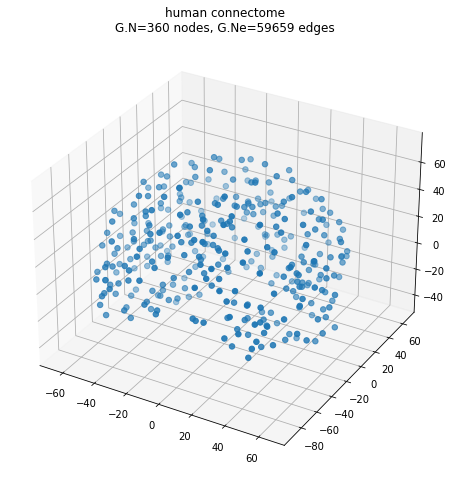

In [7]:
fig = plt.figure(figsize = (18, 8))
ax = fig.add_subplot(121, projection = '3d')
G.plot(ax = ax, vertex_size = 30)

In [8]:
plt.close(fig)

In [9]:
log_connectivity = np.log(connectivity, out=np.zeros_like(connectivity), where=(connectivity!=0))

In [10]:
connectivity_vec = connectivity.flatten()

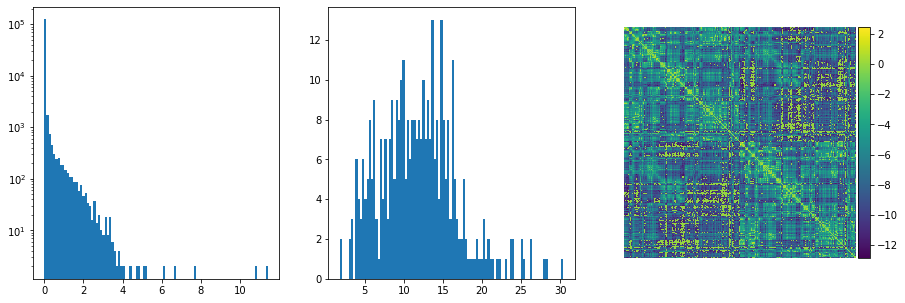

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

adj = ax[2].matshow(log_connectivity)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(adj, cax, orientation = 'vertical')

ax[2].axis('off')

ax[0].hist(connectivity.flatten(), bins = 100, log = True)
ax[1].hist(G.dw, bins = 100)
plt.show()

In [12]:
plt.close(fig)

In [13]:
G.compute_fourier_basis()

Text(0.5, 1.0, 'Eigenvectors of G')

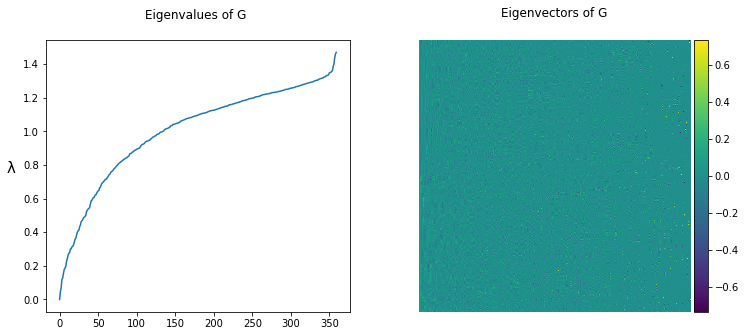

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(G.e)
ax[0].set_title('Eigenvalues of G \n')
ax[0].set_ylabel('λ   ', rotation = 0, fontsize = 15)

eigenvectors = ax[1].matshow(G.U)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(eigenvectors, cax, orientation = 'vertical')

ax[1].axis('off')
ax[1].set_title('Eigenvectors of G')

In [15]:
plt.close(fig)

In [16]:
dists = np.array([[np.linalg.norm(coords[i] - coords[j]) for j in range(G.N)] for i in range(G.N)])

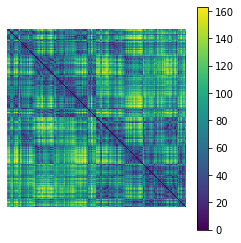

In [17]:
plt.matshow(dists)
plt.colorbar()
plt.axis('off')
plt.show()

In [18]:
plt.close(fig)

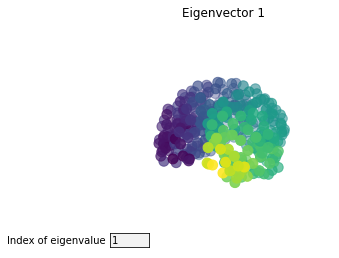

In [19]:
# %matplotlib notebook
i = 1
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(G.coords[:, 0], G.coords[:, 1], G.coords[:, 2], s = 100, c = G.U.T[i])
# G.plot_signal(G.U.T[i], ax = ax, colorbar = False)
ax.axis('off')
ax.set_title('Eigenvector %s' %(i))
# cmap = plt.cm.get_cmap()
# brain.set_array(G.U.T[i])
ax_index = plt.axes([0.25, 0.1, 0.09, 0.05])
index_textbox = TextBox(
    ax_index, label = 'Index of eigenvalue', initial='1', color='.95', hovercolor='1', label_pad=0.1,
)

def update(val):
    ax.clear()
    index = int(val)
    ax.scatter(G.coords[:, 0], G.coords[:, 1], G.coords[:, 2], c = G.U.T[index], s = 100)
#     brain.set_array(G.U.T[index])
    ax.axis('off')
    ax.set_title('Eigenvector %s' %(index)) 
#     fig.canvas.draw()
#     plt.draw()


index_textbox.on_submit(update)
plt.show()
# ax.elev = 100
# ax.azim = 20
    

In [20]:
signals = sio.loadmat(datadir / 'RS_TCs.mat')['RS_TCs']

In [21]:
print('Number of fMRI signals: %s' %(np.shape(signals[0])))

Number of fMRI signals: 1190


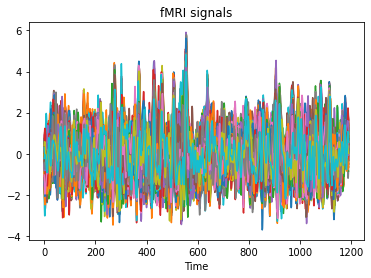

In [22]:
fig, ax = plt.subplots()
ax.plot(signals.T)
ax.set_title('fMRI signals')
ax.set_xlabel('Time')
plt.show() #cada linha é um vértice ao longo do tempo

In [23]:
plt.close(fig)

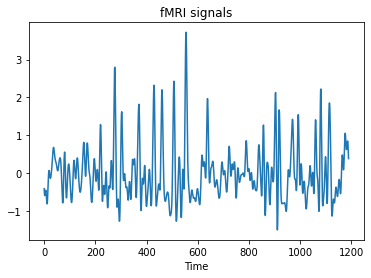

In [24]:
fig, ax = plt.subplots()
ax.plot(signals.mean(axis = 0))
ax.set_title('fMRI signals')
ax.set_xlabel('Time')
plt.show()

In [25]:
plt.close(fig)

In [26]:
%matplotlib inline
plt.rc('animation', embed_limit=100)
# fig, ax = plt.subplots(figsize=(5, 5))
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.set_aspect('auto', adjustable='box')
ax.axis('off')
plt.close(fig)
sc = ax.scatter(G.coords[:, 0], G.coords[:, 1], G.coords[:, 2])
cmap = plt.cm.get_cmap()

def animate(i):
    sc.set_color(cmap(signals[:, i]))
    ax.azim += 0.25
    ax.set_title(f'time {i}')
    return (sc,)

# animation = mpl.animation.FuncAnimation(fig, animate, blit=True,
#                                         frames=signals.shape[1], interval=50)
# ipd.HTML(animation.to_jshtml())

In [27]:
# animation.save('rotating-fmri-brain.mp4')

In [28]:
np.shape(signals), np.shape(G.L)

((360, 1190), (360, 360))

In [29]:
smoothness = signals.T @ G.L @ signals / (np.linalg.norm(signals))

In [30]:
np.shape(smoothness)

(1190, 1190)

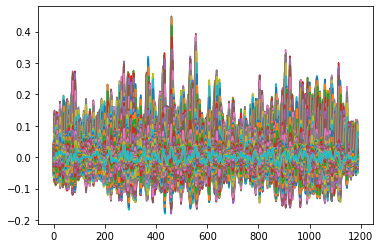

In [31]:
fig, ax = plt.subplots()

ax.plot(smoothness)
plt.show()

In [32]:
plt.close(fig)